In [2]:
# Standard Library
import random
import warnings

# Data Processing
import numpy as np
import pandas as pd
import geopandas as gpd

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

# Statistics & Spatial Regression (GWR/MGWR)
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from mgwr.gwr import MGWR
from mgwr.sel_bw import Sel_BW

# Machine Learning (Scikit-Learn)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Deep Learning (PyTorch)
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

In [3]:
chicago = gpd.read_file(r"chicago_tnp.geojson")
chicago['pct_white'] = 1-chicago['pct_nonwhite']

chicago['x_coord'] = chicago.geometry.centroid.x
chicago['y_coord'] = chicago.geometry.centroid.y

chicago['Trips_log'] = np.log(chicago['TripCount'])
chicago['PD_log'] = np.log(chicago['population_den'])

X_vars = ['pct_18to34','pct_white','pct_bachelorORhigher',
          'pct_no_vehicle','PD_log','job_entropy','network_den',
          'TripMiles_mean','pct_share']

X = chicago[X_vars]
X_coords = chicago[X_vars + ['x_coord','y_coord']]

coords = chicago[['x_coord','y_coord']].values

y = chicago['Trips_log']

C:\Users\hcz\AppData\Local\Temp\ipykernel_31116\2337528058.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  chicago['x_coord'] = chicago.geometry.centroid.x
C:\Users\hcz\AppData\Local\Temp\ipykernel_31116\2337528058.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  chicago['y_coord'] = chicago.geometry.centroid.y


Figure 8：Correlation matrix of the features used in predictive models.Note the substantial negative correlation (r = -0.82) between pct_share and socioeconomic indicators

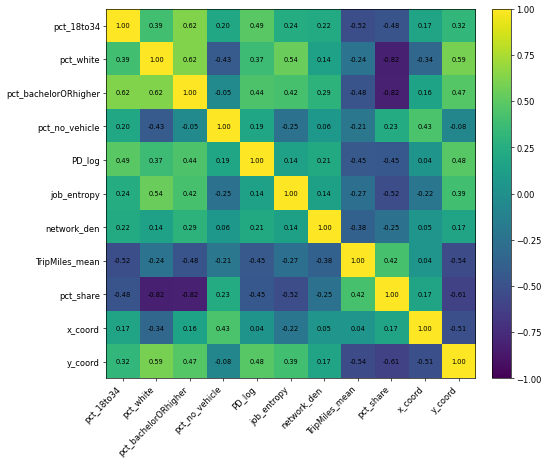

In [ ]:
corr = X_coords.corr()
n = len(corr)

fig, ax = plt.subplots(figsize=(9, 8), dpi=60) # adjust the dpi

im = ax.imshow(corr, vmin=-1, vmax=1)
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

ax.set_xticks(range(n), corr.columns, rotation=45, ha='right')
ax.set_yticks(range(n), corr.columns)

for i in range(n):
    for j in range(n):
        ax.text(j, i, f"{corr.iloc[i, j]:.2f}", ha="center", va="center", fontsize=8)

plt.show()

In [8]:
X_aug = add_constant(X)
vif = pd.DataFrame({'Variable': X_aug.columns, 'VIF': [variance_inflation_factor(X_aug.values, i) for i in range(X_aug.shape[1])]})
print(vif[vif['Variable'] != 'const'].sort_values('VIF', ascending=False))

               Variable       VIF
9             pct_share  6.358636
2             pct_white  4.367251
3  pct_bachelorORhigher  4.022545
1            pct_18to34  2.088618
8        TripMiles_mean  1.766850
4        pct_no_vehicle  1.679811
5                PD_log  1.633881
6           job_entropy  1.526251
7           network_den  1.191938


OLS

In [9]:
X = sm.add_constant(chicago[X_vars])
y = chicago['Trips_log']
print(sm.OLS(y, X, missing='drop').fit().summary())

                            OLS Regression Results                            
Dep. Variable:              Trips_log   R-squared:                       0.729
Model:                            OLS   Adj. R-squared:                  0.726
Method:                 Least Squares   F-statistic:                     234.7
Date:                Mon, 05 Jan 2026   Prob (F-statistic):          9.13e-216
Time:                        23:39:43   Log-Likelihood:                -1095.7
No. Observations:                 795   AIC:                             2211.
Df Residuals:                     785   BIC:                             2258.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    9.6451 

MGWR

In [10]:
X_in = (X - X.mean()).values
y_in = y.values.reshape(-1, 1)

sel = Sel_BW(coords, y_in, X_in, multi=True)
sel.search(verbose=False)
result = MGWR(coords, y_in, X_in, selector=sel).fit()
result.summary()

c:\Users\hcz\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Inference: 100%|██████████| 1/1 [00:00<?, ?it/s]

Model type                                                         Gaussian
Number of observations:                                                 795
Number of covariates:                                                    10

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                            732.799
Log-likelihood:                                                   -1095.671
AIC:                                                               2211.343
AICc:                                                              2213.680
BIC:                                                              -4509.700
R2:                                                                   0.729
Adj. R2:                                                              0.726

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [11]:
SEED, DEV = 2025, torch.device("cuda" if torch.cuda.is_available() else "cpu")
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

X_tr, X_te, y_tr, y_te = train_test_split(X_coords.values, y.values, test_size=0.2, random_state=SEED)
sc = StandardScaler()
X_tr = torch.tensor(sc.fit_transform(X_tr), dtype=torch.float32).to(DEV)
X_te = torch.tensor(sc.transform(X_te), dtype=torch.float32).to(DEV)
y_tr = torch.tensor(y_tr.reshape(-1, 1), dtype=torch.float32).to(DEV)
y_te = torch.tensor(y_te.reshape(-1, 1), dtype=torch.float32).to(DEV)

loader = DataLoader(TensorDataset(X_tr, y_tr), batch_size=32, shuffle=True)

layers = []
in_dim = X_tr.shape[1]
for h in [256, 256, 256]:
    layers.extend([nn.Linear(in_dim, h), nn.ELU(), nn.Dropout(0.2)])
    in_dim = h
layers.append(nn.Linear(in_dim, 1))
model = nn.Sequential(*layers).to(DEV)

opt = torch.optim.Adam(model.parameters(), lr=5e-6, weight_decay=1e-4)
loss_fn = nn.MSELoss()

for ep in range(1, 5001):
    model.train()
    for xb, yb in loader:
        loss = loss_fn(model(xb), yb)
        opt.zero_grad(); loss.backward(); opt.step()

    if ep % 500 == 0:
        model.eval()
        with torch.no_grad():
            r2_tr = r2_score(y_tr.cpu(), model(X_tr).cpu())
            r2_te = r2_score(y_te.cpu(), model(X_te).cpu())
        print(f"Ep {ep}: Train R2 {r2_tr:.4f} | Test R2 {r2_te:.4f}")

Ep 500: Train R2 0.7445 | Test R2 0.7490
Ep 1000: Train R2 0.7606 | Test R2 0.7755
Ep 1500: Train R2 0.7674 | Test R2 0.7835
Ep 2000: Train R2 0.7736 | Test R2 0.7891
Ep 2500: Train R2 0.7805 | Test R2 0.7935
Ep 3000: Train R2 0.7872 | Test R2 0.7967
Ep 3500: Train R2 0.7933 | Test R2 0.7976
Ep 4000: Train R2 0.7978 | Test R2 0.7996
Ep 4500: Train R2 0.8003 | Test R2 0.8008
Ep 5000: Train R2 0.8033 | Test R2 0.8023


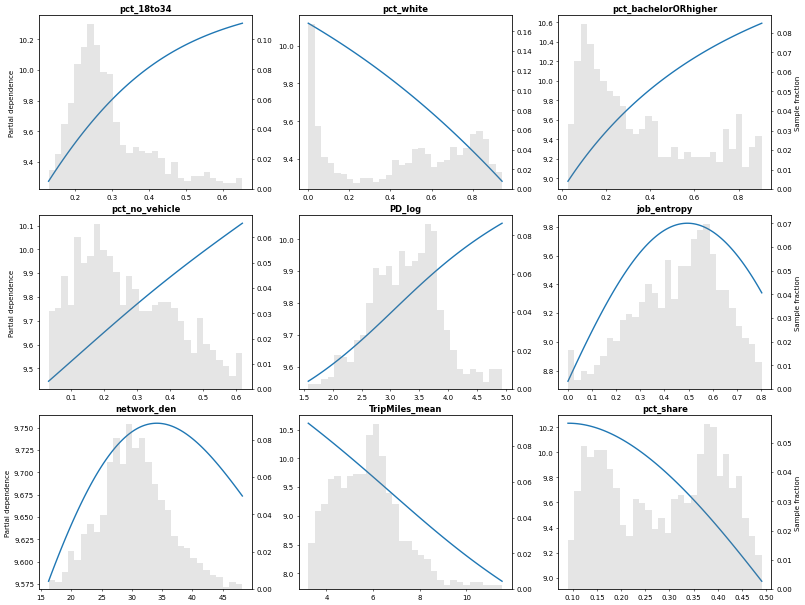

In [13]:
X_raw = X_coords.values
x_scaler = StandardScaler()
Xz = x_scaler.fit_transform(X_raw)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval().to(device)

@torch.no_grad()
def get_pdp(feat_idx, grid=120):
    x_val = X_raw[:, feat_idx]
    grid_vals = np.linspace(np.quantile(x_val, 0.01), np.quantile(x_val, 0.99), grid)
    mu, sd = x_scaler.mean_[feat_idx], x_scaler.scale_[feat_idx]
    
    base = Xz.copy()
    y_mean = []
    
    for val in grid_vals:
        base[:, feat_idx] = (val - mu) / sd
        preds = []
        for i in range(0, len(base), 128):
            b = torch.tensor(base[i:i+128], dtype=torch.float32, device=device)
            preds.append(model(b).cpu().numpy().ravel())
        y_mean.append(np.concatenate(preds).mean())
        
    return grid_vals, y_mean, x_val

fig, axes = plt.subplots(3, 3, figsize=(16, 12), constrained_layout=True, dpi=50) # adjust the dpi
feature_names = list(X_vars)

for i, (ax, var) in enumerate(zip(axes.flat, feature_names)):
    grid, pdp, raw = get_pdp(feature_names.index(var))
    
    ax.plot(grid, pdp, lw=2, color='#1f77b4')
    ax.set_title(var, fontweight='bold')
    
    if i % 3 == 0:
        ax.set_ylabel("Partial dependence")
    
    ax2 = ax.twinx()
    mask = (raw >= grid.min()) & (raw <= grid.max())
    x_hist = raw[mask]
    
    ax2.hist(x_hist, bins=30, weights=np.ones_like(x_hist)/x_hist.size, 
             alpha=0.2, color='gray', ec='none')
    
    if i % 3 == 2:
        ax2.set_ylabel("Sample fraction")

plt.show()

Figure 9: Partial dependence relationship between features and trip demand

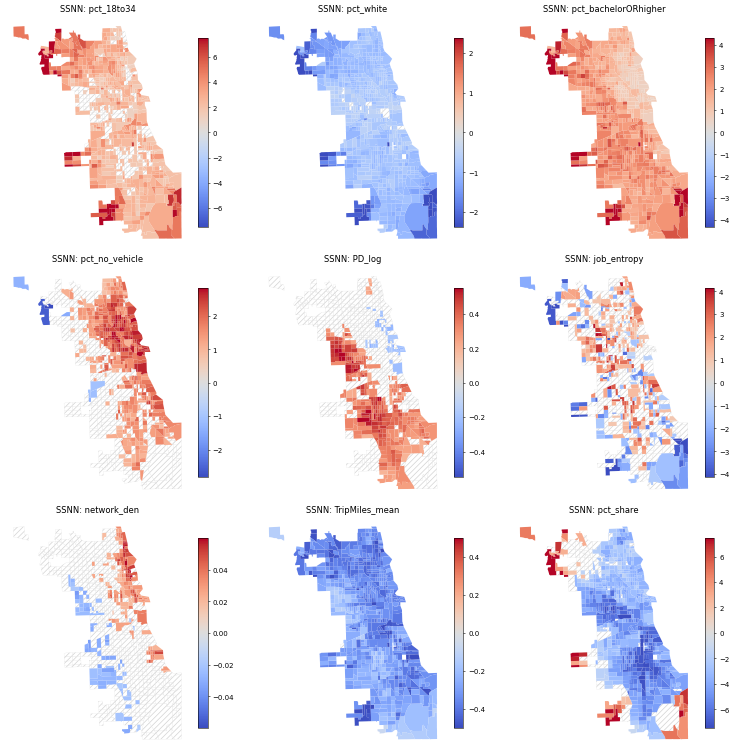

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device).train()

cols = X_vars + ['x_coord', 'y_coord']
df = chicago.dropna(subset=['Trips_log'] + cols).copy()
X_t = torch.tensor(x_scaler.transform(df[cols].values), dtype=torch.float32, device=device).requires_grad_(True)

grads = []
for _ in range(100):
    if X_t.grad is not None: X_t.grad.zero_()
    model(X_t).sum().backward()
    grads.append(X_t.grad.cpu().numpy())

g_stack = np.array(grads) / x_scaler.scale_
means, lows, highs = g_stack.mean(0), np.percentile(g_stack, 2.5, 0), np.percentile(g_stack, 97.5, 0)

fig, axes = plt.subplots(3, 3, figsize=(15, 15), constrained_layout=True, dpi=50) # adjust the dpi

for i, (ax, var) in enumerate(zip(axes.flat, X_vars)):
    idx = cols.index(var)
    val, lo, hi = means[:, idx], lows[:, idx], highs[:, idx]
    sig = (lo > 0) | (hi < 0)
    
    if (~sig).any():
        df[~sig].plot(ax=ax, facecolor="white", edgecolor="lightgray", hatch="///", lw=0.2, aspect='equal')

    if sig.any():
        vm = np.percentile(np.abs(val[sig]), 98) or 1.0
        norm = TwoSlopeNorm(vmin=-vm, vcenter=0, vmax=vm)
        df[sig].plot(ax=ax, column=val[sig], cmap="coolwarm", norm=norm, lw=0, aspect='equal')
        plt.colorbar(mpl.cm.ScalarMappable(norm, "coolwarm"), ax=ax, fraction=0.046, pad=0.04)

    ax.set_title(f"SSNN: {var}")
    ax.set_axis_off()  

for ax in axes.flat[len(X_vars):]: fig.delaxes(ax)
plt.show()

Figure 10: Spatial distribution of local marginal effects. Note: Diagonally hatched tracts denote effects that are not statistically significant at the 5% level (p > 0.05), based on Monte Carlo t-statistics; colored tracts indicate statistically significant effects, with the colormap centered at zero.

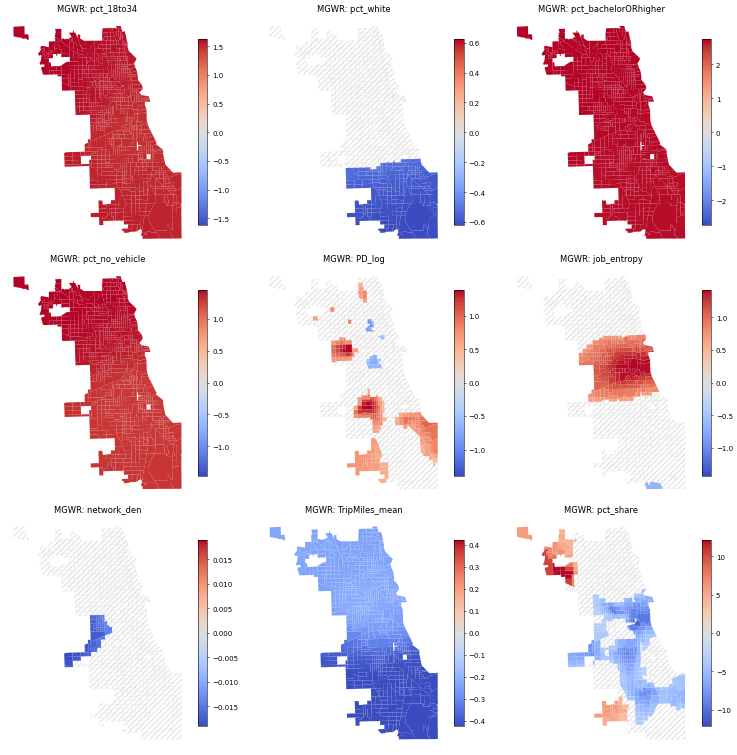

In [16]:
data = chicago.copy()
for j, var in enumerate(X_vars):
    data[f"b_{var}"] = result.params[:, j+1]
    data[f"t_{var}"] = result.tvalues[:, j+1]

fig, axes = plt.subplots(3, 3, figsize=(15, 15), constrained_layout=True, dpi=50) # adjust the dpi

for ax, var in zip(axes.flat, X_vars):
    b_col, t_col = f"b_{var}", f"t_{var}"
    gdf = data.dropna(subset=[b_col, t_col])
    sig = np.abs(gdf[t_col]) > 1.96

    if (~sig).any():
        gdf[~sig].plot(ax=ax, facecolor="white", edgecolor="lightgray", hatch="///", lw=0.2, aspect='equal')

    if sig.any():
        vals = gdf.loc[sig, b_col]
        vm = np.percentile(np.abs(vals), 98) or 1.0
        norm = TwoSlopeNorm(vmin=-vm, vcenter=0, vmax=vm)
        gdf[sig].plot(ax=ax, column=b_col, cmap="coolwarm", norm=norm, lw=0, aspect='equal')
        plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap="coolwarm"), ax=ax, fraction=0.046, pad=0.04)

    ax.set_title(f"MGWR: {var}")
    ax.set_axis_off()

for ax in axes.flat[len(X_vars):]:
    fig.delaxes(ax)

plt.show()

Figure A1: Visualization of MGWR coefficient surfaces. Each panel shows the estimated local coefficient for one covariate. Non-significant tracts (|t| ≤ 1.96) are indicated by diagonal hatching; colored tracts denote significant local effects. Colors are centered at zero, with intensity proportional to the coefficient magnitude.

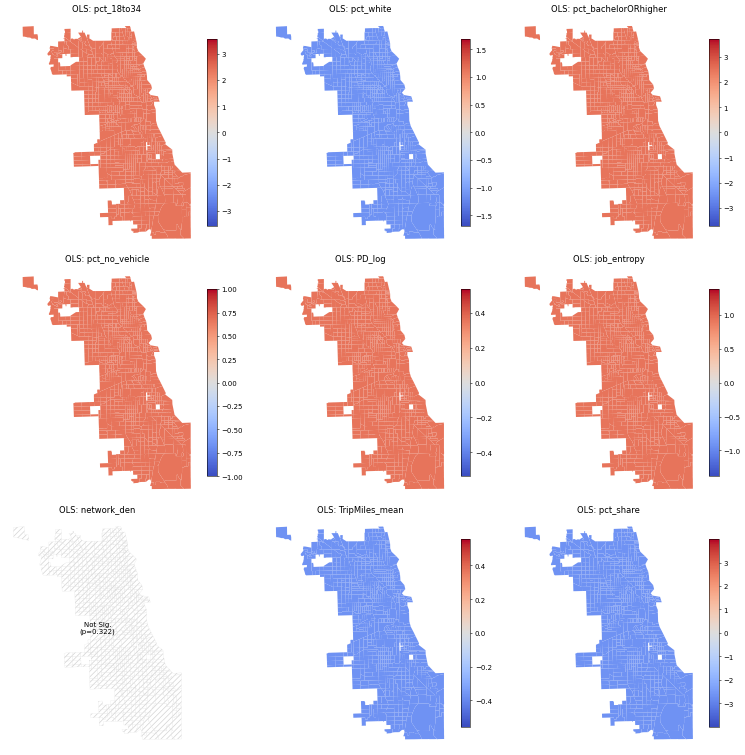

In [17]:
X_ols = sm.add_constant(chicago[X_vars])
ols_res = sm.OLS(chicago['Trips_log'], X_ols, missing='drop').fit()

fig, axes = plt.subplots(3, 3, figsize=(15, 15), constrained_layout=True, dpi=50) # adjust the dpi
df_plot = chicago.copy()

for ax, var in zip(axes.flat, X_vars):
    beta, pval = ols_res.params[var], ols_res.pvalues[var]
    
    if pval >= 0.05:
        df_plot.plot(ax=ax, facecolor="white", edgecolor="lightgray", hatch="///", lw=0.2, aspect='equal')
        ax.text(0.5, 0.5, f"Not Sig.\n(p={pval:.3f})", transform=ax.transAxes, ha='center')
    else:
        df_plot['val'] = beta
        lim = abs(beta) * 1.5 or 1.0
        norm = TwoSlopeNorm(vmin=-lim, vcenter=0, vmax=lim)
        df_plot.plot(ax=ax, column='val', cmap="coolwarm", norm=norm, aspect='equal')
        plt.colorbar(mpl.cm.ScalarMappable(norm, "coolwarm"), ax=ax, fraction=0.046, pad=0.04)

    ax.set_title(f"OLS: {var}")
    ax.set_axis_off()

for ax in axes.flat[len(X_vars):]: fig.delaxes(ax)
plt.show()